# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


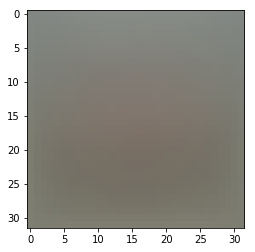

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.122205


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -11.733869 analytic: -11.733532, relative error: 1.436783e-05
numerical: 10.993851 analytic: 10.993440, relative error: 1.872393e-05


numerical: 8.654138 analytic: 8.654558, relative error: 2.423762e-05


numerical: -4.872226 analytic: -4.872377, relative error: 1.552990e-05


numerical: -38.751473 analytic: -38.751528, relative error: 7.113122e-07


numerical: -60.966569 analytic: -60.966456, relative error: 9.264676e-07
numerical: 4.180784 analytic: 4.180601, relative error: 2.189149e-05


numerical: -4.556525 analytic: -4.556439, relative error: 9.417413e-06
numerical: 1.800836 analytic: 1.800831, relative error: 1.388880e-06


numerical: 13.595453 analytic: 13.595507, relative error: 1.988435e-06


numerical: 12.615550 analytic: 12.625394, relative error: 3.899876e-04
numerical: 3.258102 analytic: 3.255547, relative error: 3.922733e-04


numerical: 6.874090 analytic: 6.876425, relative error: 1.697933e-04
numerical: 31.417841 analytic: 31.418630, relative error: 1.255463e-05


numerical: 4.387253 analytic: 4.390999, relative error: 4.267432e-04
numerical: -31.339902 analytic: -31.339410, relative error: 7.846468e-06


numerical: -9.951036 analytic: -9.945077, relative error: 2.995075e-04
numerical: 37.943622 analytic: 37.967225, relative error: 3.109418e-04


numerical: 11.371842 analytic: 11.371311, relative error: 2.334630e-05


numerical: 13.884195 analytic: 13.868429, relative error: 5.680840e-04


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [63]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.074495e+00 computed in 0.089000s
Vectorized loss: 9.074495e+00 computed in 0.003004s
difference: 0.000000


In [64]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.087980s
Vectorized loss and gradient: computed in 0.003007s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [65]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.066078
iteration 100 / 1500: loss 774.483438
iteration 200 / 1500: loss 769.936048
iteration 300 / 1500: loss 767.731271
iteration 400 / 1500: loss 764.454347
iteration 500 / 1500: loss 762.980489
iteration 600 / 1500: loss 759.412852
iteration 700 / 1500: loss 757.989604
iteration 800 / 1500: loss 755.670289
iteration 900 / 1500: loss 755.048171
iteration 1000 / 1500: loss 752.982764
iteration 1100 / 1500: loss 750.722820
iteration 1200 / 1500: loss 749.473508
iteration 1300 / 1500: loss 746.572357
iteration 1400 / 1500: loss 745.308646
That took 9.233980s


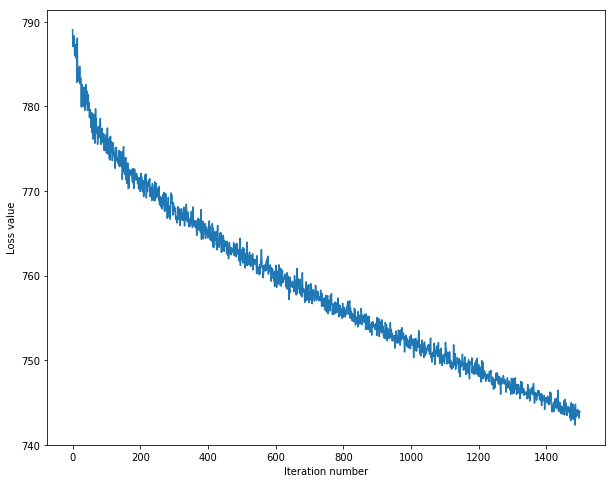

In [66]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [67]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.305449
validation accuracy: 0.303000


In [71]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
best_val = float('inf')
best_hyperparameters = (0, 0)
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        hyperparameters = (lr, rs)
        train_loss = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=False)[-1]
        train_acc = np.mean(svm.predict(X_train) == y_train)
        val_loss, _ = svm.loss(X_val, y_val, rs)
        val_acc = np.mean(svm.predict(X_val) == y_val)
        if(val_loss < best_val):
            best_val = val_loss
            best_hyperparameters = hyperparameters
            best_svm = svm
        print("@parameter %s, loss:%.3f" % (hyperparameters, val_loss))
        results[hyperparameters] = (train_acc, val_acc)
best_svm = LinearSVM()
best_train_loss = best_svm.train(X_train, y_train, learning_rate=best_hyperparameters[0], reg=best_hyperparameters[1],
              num_iters=100000, verbose=True)[-1]
best_val = np.sum(best_svm.predict(X_val) == y_val) / X_val.shape[0]
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

@parameter (1e-07, 25000.0), loss:745.604
@parameter (1e-07, 50000.0), loss:1503.556
@parameter (5e-05, 25000.0), loss:15984.462
@parameter (5e-05, 50000.0), loss:31247.754
iteration 0 / 100000: loss 795.688106
iteration 100 / 100000: loss 776.805764
iteration 200 / 100000: loss 771.104029
iteration 300 / 100000: loss 768.490448
iteration 400 / 100000: loss 764.344735
iteration 500 / 100000: loss 761.051950
iteration 600 / 100000: loss 759.547008
iteration 700 / 100000: loss 755.906680
iteration 800 / 100000: loss 754.744434
iteration 900 / 100000: loss 752.847645
iteration 1000 / 100000: loss 751.277122
iteration 1100 / 100000: loss 749.632994
iteration 1200 / 100000: loss 747.241918
iteration 1300 / 100000: loss 745.565375
iteration 1400 / 100000: loss 743.138846
iteration 1500 / 100000: loss 741.583178
iteration 1600 / 100000: loss 741.744153
iteration 1700 / 100000: loss 739.021662
iteration 1800 / 100000: loss 736.889498
iteration 1900 / 100000: loss 735.946796
iteration 2000 / 10

iteration 19400 / 100000: loss 639.822740
iteration 19500 / 100000: loss 638.854255
iteration 19600 / 100000: loss 639.301569
iteration 19700 / 100000: loss 638.507810
iteration 19800 / 100000: loss 638.219525
iteration 19900 / 100000: loss 638.135959
iteration 20000 / 100000: loss 637.755682
iteration 20100 / 100000: loss 637.310032
iteration 20200 / 100000: loss 637.354542
iteration 20300 / 100000: loss 637.146058
iteration 20400 / 100000: loss 636.250852
iteration 20500 / 100000: loss 636.969916
iteration 20600 / 100000: loss 635.952400
iteration 20700 / 100000: loss 636.452254
iteration 20800 / 100000: loss 635.578616
iteration 20900 / 100000: loss 634.594207
iteration 21000 / 100000: loss 635.522349
iteration 21100 / 100000: loss 635.015208
iteration 21200 / 100000: loss 634.810814
iteration 21300 / 100000: loss 634.554224
iteration 21400 / 100000: loss 634.228978
iteration 21500 / 100000: loss 633.957242
iteration 21600 / 100000: loss 633.884610
iteration 21700 / 100000: loss 633

iteration 39000 / 100000: loss 604.937137
iteration 39100 / 100000: loss 604.797028
iteration 39200 / 100000: loss 603.955323
iteration 39300 / 100000: loss 604.863107
iteration 39400 / 100000: loss 604.409353
iteration 39500 / 100000: loss 604.772986
iteration 39600 / 100000: loss 603.908399
iteration 39700 / 100000: loss 604.065092
iteration 39800 / 100000: loss 604.336922
iteration 39900 / 100000: loss 603.445643
iteration 40000 / 100000: loss 604.292364
iteration 40100 / 100000: loss 603.193118
iteration 40200 / 100000: loss 603.676824
iteration 40300 / 100000: loss 603.567233
iteration 40400 / 100000: loss 602.917805
iteration 40500 / 100000: loss 603.086619
iteration 40600 / 100000: loss 602.933862
iteration 40700 / 100000: loss 603.136718
iteration 40800 / 100000: loss 602.968631
iteration 40900 / 100000: loss 602.881273
iteration 41000 / 100000: loss 602.825185
iteration 41100 / 100000: loss 602.355395
iteration 41200 / 100000: loss 602.350079
iteration 41300 / 100000: loss 602

iteration 58600 / 100000: loss 590.119728
iteration 58700 / 100000: loss 589.810512
iteration 58800 / 100000: loss 589.708846
iteration 58900 / 100000: loss 590.088936
iteration 59000 / 100000: loss 590.361802
iteration 59100 / 100000: loss 589.774451
iteration 59200 / 100000: loss 589.436630
iteration 59300 / 100000: loss 589.624923
iteration 59400 / 100000: loss 589.496086
iteration 59500 / 100000: loss 589.212445
iteration 59600 / 100000: loss 590.085853
iteration 59700 / 100000: loss 589.675378
iteration 59800 / 100000: loss 589.080557
iteration 59900 / 100000: loss 588.868566
iteration 60000 / 100000: loss 588.716474
iteration 60100 / 100000: loss 589.292870
iteration 60200 / 100000: loss 589.068635
iteration 60300 / 100000: loss 589.208580
iteration 60400 / 100000: loss 588.850245
iteration 60500 / 100000: loss 588.757800
iteration 60600 / 100000: loss 589.112833
iteration 60700 / 100000: loss 588.906408
iteration 60800 / 100000: loss 589.327521
iteration 60900 / 100000: loss 588

iteration 78200 / 100000: loss 584.125296
iteration 78300 / 100000: loss 583.838941
iteration 78400 / 100000: loss 584.461807
iteration 78500 / 100000: loss 583.866786
iteration 78600 / 100000: loss 583.960830
iteration 78700 / 100000: loss 583.793708
iteration 78800 / 100000: loss 584.096346
iteration 78900 / 100000: loss 584.186679
iteration 79000 / 100000: loss 583.749724
iteration 79100 / 100000: loss 583.672595
iteration 79200 / 100000: loss 584.083987
iteration 79300 / 100000: loss 583.970875
iteration 79400 / 100000: loss 584.794087
iteration 79500 / 100000: loss 583.965553
iteration 79600 / 100000: loss 584.107778
iteration 79700 / 100000: loss 584.511370
iteration 79800 / 100000: loss 583.996276
iteration 79900 / 100000: loss 584.309783
iteration 80000 / 100000: loss 583.614989
iteration 80100 / 100000: loss 583.900004
iteration 80200 / 100000: loss 584.002003
iteration 80300 / 100000: loss 584.145587
iteration 80400 / 100000: loss 584.445694
iteration 80500 / 100000: loss 583

iteration 97800 / 100000: loss 583.757416
iteration 97900 / 100000: loss 584.578997
iteration 98000 / 100000: loss 584.052284
iteration 98100 / 100000: loss 584.703928
iteration 98200 / 100000: loss 584.510282
iteration 98300 / 100000: loss 583.923193
iteration 98400 / 100000: loss 584.201112
iteration 98500 / 100000: loss 583.759208
iteration 98600 / 100000: loss 584.569502
iteration 98700 / 100000: loss 583.970035
iteration 98800 / 100000: loss 583.832232
iteration 98900 / 100000: loss 584.108132
iteration 99000 / 100000: loss 583.947115
iteration 99100 / 100000: loss 584.123346
iteration 99200 / 100000: loss 584.467045
iteration 99300 / 100000: loss 584.071124
iteration 99400 / 100000: loss 584.374313
iteration 99500 / 100000: loss 583.945582
iteration 99600 / 100000: loss 584.628818
iteration 99700 / 100000: loss 584.124175
iteration 99800 / 100000: loss 584.359274
iteration 99900 / 100000: loss 584.004633
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.302020 val accuracy: 0.31

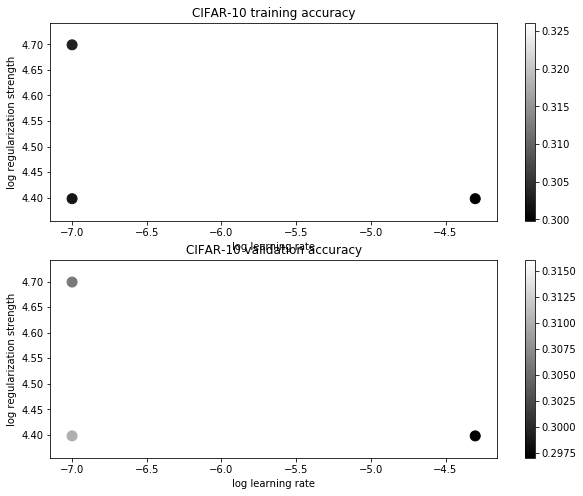

In [74]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [76]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.360000


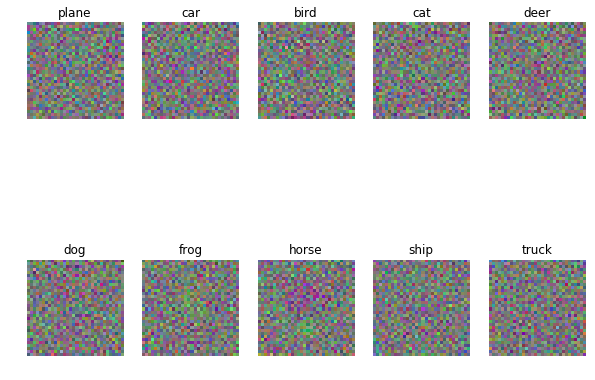

In [78]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*